### This jupyter notebook uses the predicted states using the siRNA knockout transcriptome ( results form Example2_KNN_ALL.ipynb) and the gene kncokout effects from the DepMap data (depmap.org/portal/download, DepMap Public 19Q3) to predict the targetable vulnerability.

#### Load libraries

In [106]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import scipy 
import scipy.stats as ss
import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest
sys.path.append('../Script/')
import FM_States
import FM_selection
import TF
#from FM_States import *
import rpy2
from rpy2.robjects.packages import importr

base = importr('base')
CC = importr('ConsensusClusterPlus')
pheatmap = importr('pheatmap')
bezier = importr('bezier')

ROOT_DIR = os.path.abspath("../")

### Input from the results of Example2_KNN_ALL.ipynb

In [131]:
para = {
    'input_dir': ROOT_DIR+"/Sample_input/Example2/",
    'output_dir': ROOT_DIR+"/Sample_output/Example2/",
    'KNN_labels':ROOT_DIR+"/Sample_output/Example2/Predicted_gene_allSet2.csv",
    'annotation_col':ROOT_DIR +  "/Sample_output/Example1/annotation_col.csv",
    'Gene_effect_Depmap':ROOT_DIR+"/Dataset/Achilles_gene_effect.csv"
}

In [155]:
Result = pd.read_csv(para['KNN_labels'])
output_dir = para['output_dir']

annotation_col_1 = pd.read_csv(para['annotation_col'], index_col= 'Unnamed: 0')
states = sorted(list(set(annotation_col_1['States'])))
colors = ['#ff8080','pink','#fdd5ac','#8895df', 'cyan'] #Define the colors for cluster annotation


In [156]:
Result.loc[Result['Gene'] == 'RPS7']
x = list(meta_sh[meta_sh['pert_iname'] == 'RPS7'].index)

In [157]:
set(dic_sh_state['S4']).intersection(x)

set()

#### Use the Crisper knockout data in Depmap to annotate the knockout effects for gene knockout which drive to different cell states. Depmap 2019 Q3 was used. 

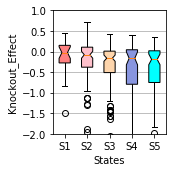

In [168]:
knockdown_DepMap = pd.read_csv(para['Gene_effect_Depmap'], index_col = 'Unnamed: 0')

df = pd.DataFrame(data=knockdown_DepMap, index=knockdown_DepMap.index, columns =knockdown_DepMap.columns.values )

MCF7_gene_effect_Depmap = df.loc['ACH-000019']
new_index_list = []
for item in list(MCF7_gene_effect_Depmap.index):
    new_index_list.append(item.split('(')[0].strip())
MCF7_gene_effect_Depmap.index = new_index_list   

dic_eff = {}
data_arr = []
for state in states:
    dic_eff[state] = FM_States.intersection( list(Result.loc[Result['Label'] == state]['Gene'].values),MCF7_gene_effect_Depmap.index.tolist() )
    data_arr.append(MCF7_gene_effect_Depmap.loc[dic_eff[state]].values)
#np.random.seed(19680820)

all_data = np.array(data_arr)
labels = states
fig, ax = plt.subplots(figsize=(2.5, 2.5))
bplot2 = ax.boxplot(all_data,
                         notch=True,  # notch shape
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels[0:len(states)])  # will be used to label x-ticks

colors = colors

for patch, color in zip(bplot2['boxes'], colors):
    patch.set_facecolor(color)

ax.yaxis.grid(True)
ax.set_xlabel('States')
ax.set_ylabel('Knockout_Effect')
ax.set_ylim([-2,1])
plt.tight_layout()
plt.savefig(output_dir+'/Knockout_Effect_allSet.png', dpi=300)
plt.show()


### Compare the gene knockout effect distribution for genes which drive each state

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


S3
Ks_2sampResult(statistic=0.16281047975501872, pvalue=0.004933599620060228)
S4
Ks_2sampResult(statistic=0.23099760489428842, pvalue=0.0014503915992594128)
S5
Ks_2sampResult(statistic=0.19228841745992808, pvalue=0.0035683238422414645)


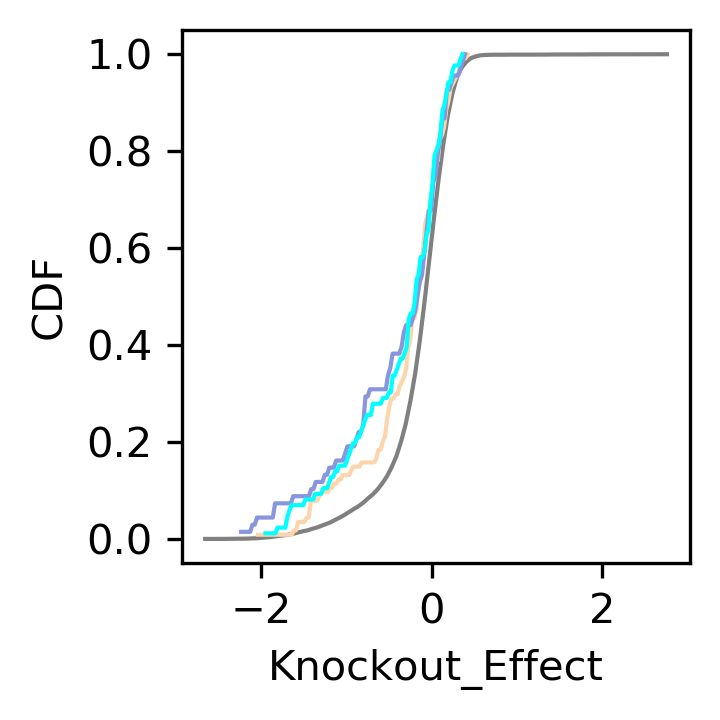

In [159]:
import numpy as np
import matplotlib.pyplot as plt

data = MCF7_gene_effect_Depmap.sort_values()
num_bins = 100
counts, bin_edges = np.histogram(data, bins=num_bins, normed=True)
cdf = np.cumsum(counts)/sum(counts)
plt.figure(num=None, figsize=(2.5, 2.5), dpi=300, facecolor='w', edgecolor='k')

plt.plot(bin_edges[1:], cdf, color='grey', linewidth=1)

for i in range(0,len(states)):
    state = states[i]
    statistic = scipy.stats.ks_2samp(MCF7_gene_effect_Depmap, MCF7_gene_effect_Depmap[dic_eff[state]].sort_values())
    if statistic[1] < 0.05:
        print(state)
        print(statistic)
        data_state = MCF7_gene_effect_Depmap[dic_eff[state]].sort_values()
        counts1, bin_edges1 = np.histogram(data_state, bins=num_bins, normed=True)
        cdf1 = np.cumsum(counts1)/sum(counts1)
        plt.tight_layout()
        plt.plot(bin_edges1[1:], cdf1, color=colors[i], linewidth=1)

plt.xlabel('Knockout_Effect')
plt.ylabel('CDF')
plt.tight_layout()
plt.savefig(output_dir+'/KS_plot_allSet.png', dpi=300)
plt.tight_layout()
plt.show()

### Get the results of "knockout effects" and the "Proportion of seeds" for each gene in each state

In [160]:
states = sorted(list(set(annotation_col_1['States'])))

dic_target = {}
for state in states:
    dic_target[state] = FM_States.intersection(list(Result.loc[Result['Label'] == state]['Gene']), MCF7_gene_effect_Depmap.index.tolist())

In [161]:
Result_sample = pd.read_csv(output_dir + "Predicted_sample_allSet.csv")

In [162]:
dic_sh_state = {}
for state in list(set(Result_sample['State'])):
    dic_sh_state[state] = list(Result_sample.loc[Result_sample['State'] == state]['Sample'])

In [163]:
meta_sh = pd.read_csv(para['input_dir']+"/MetaData_sig_info_sh_MCF7_96h.csv")  ## Annotation data for shRNA
meta_sh.index = meta_sh['sig_id']

### Potential targets for MCF7-like breast cancer that drive S5-like state

S5


<Figure size 1500x1200 with 0 Axes>

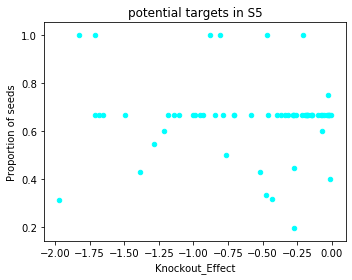

In [165]:
i = 5
state = states[i-1]  #User defination
print(state)
count = 0
Ratio_list = []
Gene_list = []
for GENE in dic_target[state]: #set(meta_sh.loc[dic_sh_state[state]]['pert_iname']):
    ratio = None
    Curr_GENE = list(meta_sh[meta_sh['pert_iname'] == GENE].index) #Curr_Gene is the samples list for one gene knockdown
    all_seeds = []
    for state1 in states:
        all_seeds = all_seeds + dic_sh_state[state1]  #all_seeds is all samples predicted for S1, S2, S3, S4 and S5
    
    
    used_list =FM_States.intersection(Curr_GENE,   all_seeds )  #Used_list is the samples with one gene knockdown that has been predicted to the States
    ratio = float(len(FM_States.intersection(Curr_GENE, dic_sh_state[state]))) / len(used_list)
    
    if (len(FM_States.intersection(Curr_GENE, dic_sh_state[state]))) > 0:
        Gene_list.append(GENE)
        Ratio_list.append(ratio)
    else:
        print(GENE)
        
d = {'GENE':Gene_list,'Proportion of seeds':Ratio_list}
pd_candidates = pd.DataFrame(d, columns=['GENE','Proportion of seeds'])
pd_candidates.index = pd_candidates['GENE']

lst1 = pd_candidates.loc[dic_target[state]]['Proportion of seeds'].values.tolist()
lst2 = MCF7_gene_effect_Depmap.loc[dic_target[state]].values.tolist()
candidata_target = pd.DataFrame(list(zip(lst1, lst2)), columns =['Proportion of seeds', 'Knockout_Effect'])
candidata_target.index = dic_target[state]

import matplotlib.pyplot as plt
import pandas as pd
plt.figure(num=None, figsize=(5, 4), dpi=300, facecolor='w', edgecolor='k')
# a scatter plot comparing num_children and num_pets
candidata_target_select = candidata_target.loc[candidata_target['Knockout_Effect'] < 0]
candidata_target_select.plot(kind='scatter',x='Knockout_Effect',y='Proportion of seeds',
                             color= colors[i-1],title="potential targets in " + state, 
                             figsize=(5,4))
plt.tight_layout()
plt.savefig(para['output_dir'] + '/target_'+state+'.png', dpi=300)
plt.show()
candidata_target_select.sort_values(['Knockout_Effect']).to_csv(para['output_dir']  + '/target_'+state+'.csv')
candidata_target.sort_values(['Knockout_Effect']).to_csv(para['output_dir']  + '/target_all_'+state+'.csv')

In [166]:
Drug_query = []
for Target in list(candidata_target.index):
    
    DT = list(DB.loc[DB['Target']==Target]['Drug'] + ['::'] +DB.loc[DB['Target']==Target]['Action'] + ['::']+ DB.loc[DB['Target']==Target]['Stage'].values)
    Drug_query.append(DT)
    
candidata_target['DT'] = Drug_query
candidata_target.sort_values(['Knockout_Effect']).to_csv(para['output_dir']  + '/target_all_'+state+'potiential_drugs.csv')

### Potential targets for MCF7-like breast cancer that drive S4-like state

S4


<Figure size 1500x1200 with 0 Axes>

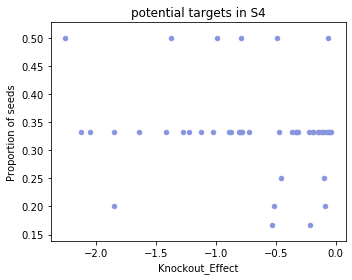

In [167]:
i = 4
state = states[i-1]  #User defination
print(state)
count = 0
Ratio_list = []
Gene_list = []
for GENE in dic_target[state]: #set(meta_sh.loc[dic_sh_state[state]]['pert_iname']):
    Curr_GENE = list(meta_sh[meta_sh['pert_iname'] == GENE].index)
    all_seeds = []
    for state1 in states:
        all_seeds = all_seeds + dic_sh_state[state1]
        
    used_list =FM_States.intersection(Curr_GENE,   all_seeds )
    if len(used_list) > 0:
        ratio = float(len(FM_States.intersection(Curr_GENE, dic_sh_state[state]))) / len(used_list)
    
        if (len(FM_States.intersection(Curr_GENE, dic_sh_state[state]))) > 0:
            Gene_list.append(GENE)
            Ratio_list.append(ratio)
        else:
            print(GENE)
        
d = {'GENE':Gene_list,'Proportion of seeds':Ratio_list}
pd_candidates = pd.DataFrame(d, columns=['GENE','Proportion of seeds'])
pd_candidates.index = pd_candidates['GENE']

lst1 = pd_candidates.loc[dic_target[state]]['Proportion of seeds'].values.tolist()
lst2 = MCF7_gene_effect_Depmap.loc[dic_target[state]].values.tolist()
candidata_target = pd.DataFrame(list(zip(lst1, lst2)), columns =['Proportion of seeds', 'Knockout_Effect'])
candidata_target.index = dic_target[state]

import matplotlib.pyplot as plt
import pandas as pd
plt.figure(num=None, figsize=(5, 4), dpi=300, facecolor='w', edgecolor='k')
# a scatter plot comparing num_children and num_pets
candidata_target_select = candidata_target[candidata_target['Knockout_Effect'] < 0]
candidata_target_select.plot(kind='scatter',x='Knockout_Effect',y='Proportion of seeds',
                             color= colors[i-1],title="potential targets in " + state, 
                             figsize=(5,4))
plt.tight_layout()
plt.savefig(para['output_dir'] + '/target_'+state+'.png', dpi=300)
plt.show()
candidata_target_select.sort_values(['Knockout_Effect']).to_csv(para['output_dir']  + '/target_'+state+'.csv')
candidata_target.sort_values(['Knockout_Effect']).to_csv(para['output_dir']  + '/target_all_'+state+'.csv')

In [150]:
import pandas as pd
File_DrugBank = "../Dataset/DrugBank_version5.16/drug_all_result.csv"

Drug_list = []
Action_list = []
Stage_list = []
Target_list = []

fin = open(File_DrugBank)
for line in fin.readlines():
    words = line.strip().split("::")
    Drug_list.append(words[0])
    Action_list.append(words[1])
    Stage_list.append(words[2])
    Target_list.append(words[3])

DB = pd.DataFrame({"Drug":Drug_list, 
                   "Action": Action_list, 
                   'Stage': Stage_list, 
                   'Target': Target_list})

fin.close()

In [152]:
Drug_query = []
for Target in list(candidata_target.index):
    
    DT = list(DB.loc[DB['Target']==Target]['Drug'] + ['::'] +DB.loc[DB['Target']==Target]['Action'] + ['::']+ DB.loc[DB['Target']==Target]['Stage'].values)
    Drug_query.append(DT)
    
candidata_target['DT'] = Drug_query
candidata_target.sort_values(['Knockout_Effect']).to_csv(para['output_dir']  + '/target_all_'+state+'potiential_drugs.csv')

### End of Example 2